# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import Shrec17DeepSphere as shrecDataset
from SHREC17.load_shrec import fix_dataset

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
download = False
train_dataset = shrecDataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


31364it [00:28, 1101.69it/s]


In [8]:
val_dataset = shrecDataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

5133it [00:04, 1212.68it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


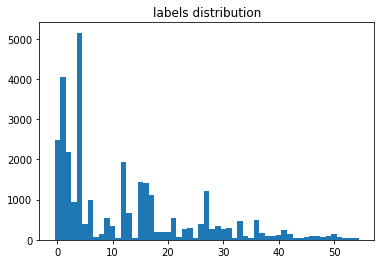

In [9]:
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [10]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
#ids = train_dataset.retrieve_ids()
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 033922


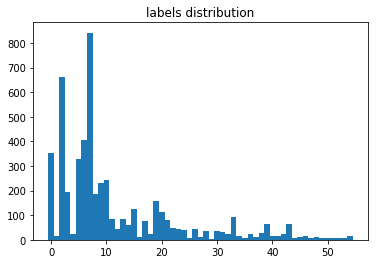

In [11]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [15]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

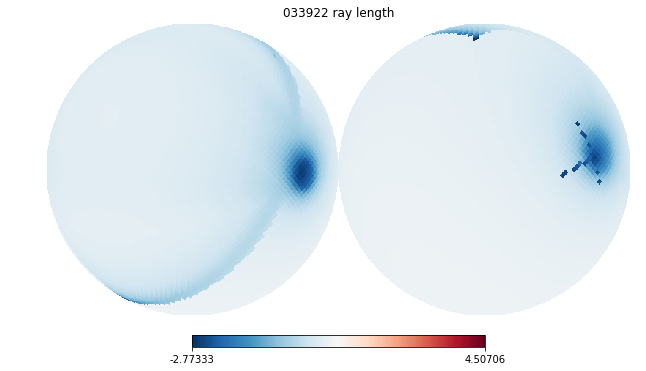

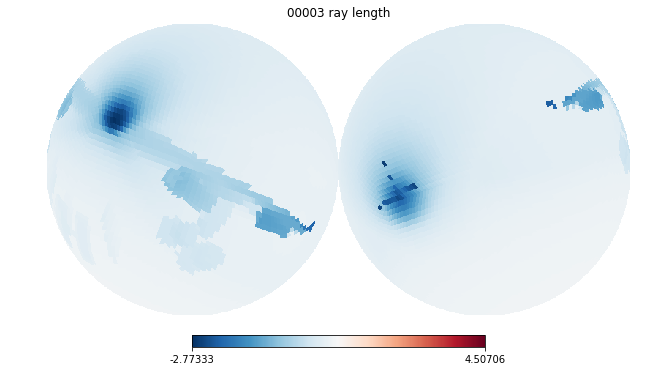

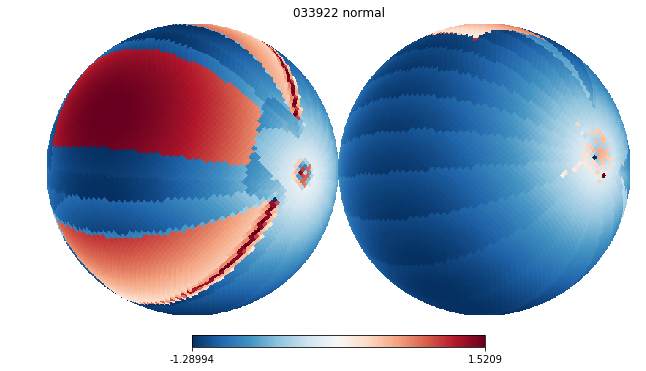

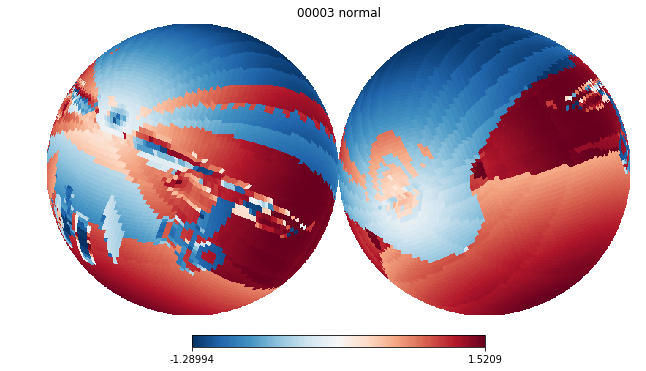

In [16]:
hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003, rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
hp.orthview(im0003_norm, rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [17]:
#training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [88]:
#EXP_NAME = 'shrec17_Cohen_simple_reg_5K_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)
EXP_NAME = 'shrec17_Cohen_simple_reg_2_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [89]:
params = hyperparameters.get_params_shrec17(training.N, EXP_NAME, Nside, train_dataset.nclass, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 8, 4]
#pixels: [12288, 768, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 15,416,033,280
Learning rate will start at 2.0e-02 and finish at 7.8e-06.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [25]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
# backup = params.copy()

# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)

# params.update(backup)

# plt.semilogx(learning_rate, loss_validation, '.-')

## 2.2 Train Network

In [26]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 58,700


In [27]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 196 / 39205 (epoch 0.20 / 40):
  learning_rate = 1.85e-02, training loss = 2.25e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 40.11 (2059 / 5133), f1 (weighted): 36.16, loss: 2.81e+00
  CPU time: 30s, wall time: 40s
step 392 / 39205 (epoch 0.40 / 40):
  learning_rate = 1.71e-02, training loss = 1.88e+00
  validation accuracy: 54.16 (2780 / 5133), f1 (weighted): 49.57, loss: 2.43e+00
  CPU time: 54s, wall time: 74s
step 588 / 39205 (epoch 0.60 / 40):
  learning_rate = 1.58e-02, training loss = 1.78e+00
  validation accuracy: 57.35 (2944 / 5133), f1 (weighted): 51.62, loss: 2.17e+00
  CPU time: 76s, wall time: 106s
step 784 / 39205 (epoch 0.80 / 40):
  learning_rate = 1.46e-02, training loss = 2.02e+00
  validation accuracy: 56.59 (2905 / 5133), f1 (weighted): 51.25, loss: 2.20e+00
  CPU time: 98s, wall time: 138s
step 980 / 39205 (epoch 1.00 / 40):
  learning_rate = 1.35e-02, training loss = 1.89e+00
  validation accuracy: 50.87 (2611 / 5133), f1 (weighted): 45.75, loss: 2.35e+00
  CPU time: 119s, wall time: 169s
step 1176 / 39205 (epoch 1.20 / 40):
  learning_rate = 1.25e-02, training l

  validation accuracy: 69.06 (3545 / 5133), f1 (weighted): 65.91, loss: 1.37e+00
  CPU time: 874s, wall time: 1289s
step 8232 / 39205 (epoch 8.40 / 40):
  learning_rate = 7.42e-04, training loss = 9.02e-01
  validation accuracy: 71.28 (3659 / 5133), f1 (weighted): 67.77, loss: 1.34e+00
  CPU time: 895s, wall time: 1319s
step 8428 / 39205 (epoch 8.60 / 40):
  learning_rate = 6.86e-04, training loss = 1.60e+00
  validation accuracy: 70.91 (3640 / 5133), f1 (weighted): 67.21, loss: 1.36e+00
  CPU time: 916s, wall time: 1350s
step 8624 / 39205 (epoch 8.80 / 40):
  learning_rate = 6.34e-04, training loss = 1.85e+00
  validation accuracy: 71.11 (3650 / 5133), f1 (weighted): 67.82, loss: 1.35e+00
  CPU time: 937s, wall time: 1381s
step 8820 / 39205 (epoch 9.00 / 40):
  learning_rate = 5.86e-04, training loss = 1.35e+00
  validation accuracy: 70.91 (3640 / 5133), f1 (weighted): 67.92, loss: 1.32e+00
  CPU time: 958s, wall time: 1413s
step 9016 / 39205 (epoch 9.20 / 40):
  learning_rate = 5.42e

step 15876 / 39205 (epoch 16.20 / 40):
  learning_rate = 3.48e-05, training loss = 1.46e+00
  validation accuracy: 72.57 (3725 / 5133), f1 (weighted): 69.59, loss: 1.24e+00
  CPU time: 1710s, wall time: 2532s
step 16072 / 39205 (epoch 16.40 / 40):
  learning_rate = 3.22e-05, training loss = 1.45e+00
  validation accuracy: 72.82 (3738 / 5133), f1 (weighted): 69.81, loss: 1.24e+00
  CPU time: 1731s, wall time: 2562s
step 16268 / 39205 (epoch 16.60 / 40):
  learning_rate = 2.98e-05, training loss = 1.26e+00
  validation accuracy: 72.49 (3721 / 5133), f1 (weighted): 69.34, loss: 1.24e+00
  CPU time: 1751s, wall time: 2594s
step 16464 / 39205 (epoch 16.80 / 40):
  learning_rate = 2.75e-05, training loss = 1.70e+00
  validation accuracy: 72.57 (3725 / 5133), f1 (weighted): 69.48, loss: 1.25e+00
  CPU time: 1773s, wall time: 2625s
step 16660 / 39205 (epoch 17.00 / 40):
  learning_rate = 2.54e-05, training loss = 1.47e+00
  validation accuracy: 72.43 (3718 / 5133), f1 (weighted): 69.55, loss: 

  validation accuracy: 72.55 (3724 / 5133), f1 (weighted): 69.53, loss: 1.24e+00
  CPU time: 2525s, wall time: 3742s
step 23716 / 39205 (epoch 24.20 / 40):
  learning_rate = 1.51e-06, training loss = 1.04e+00
  validation accuracy: 73.25 (3760 / 5133), f1 (weighted): 70.40, loss: 1.22e+00
  CPU time: 2546s, wall time: 3773s
step 23912 / 39205 (epoch 24.40 / 40):
  learning_rate = 1.40e-06, training loss = 8.39e-01
  validation accuracy: 72.94 (3744 / 5133), f1 (weighted): 70.07, loss: 1.23e+00
  CPU time: 2567s, wall time: 3804s
step 24108 / 39205 (epoch 24.60 / 40):
  learning_rate = 1.29e-06, training loss = 1.12e+00
  validation accuracy: 73.27 (3761 / 5133), f1 (weighted): 70.32, loss: 1.23e+00
  CPU time: 2588s, wall time: 3836s
step 24304 / 39205 (epoch 24.80 / 40):
  learning_rate = 1.19e-06, training loss = 1.30e+00
  validation accuracy: 72.71 (3732 / 5133), f1 (weighted): 69.71, loss: 1.24e+00
  CPU time: 2609s, wall time: 3867s
step 24500 / 39205 (epoch 25.00 / 40):
  learni

step 31360 / 39205 (epoch 32.00 / 40):
  learning_rate = 7.09e-08, training loss = 1.49e+00
  validation accuracy: 72.43 (3718 / 5133), f1 (weighted): 69.34, loss: 1.24e+00
  CPU time: 3362s, wall time: 4986s
step 31556 / 39205 (epoch 32.20 / 40):
  learning_rate = 6.56e-08, training loss = 8.64e-01
  validation accuracy: 73.43 (3769 / 5133), f1 (weighted): 70.70, loss: 1.23e+00
  CPU time: 3383s, wall time: 5017s
step 31752 / 39205 (epoch 32.40 / 40):
  learning_rate = 6.06e-08, training loss = 1.37e+00
  validation accuracy: 72.78 (3736 / 5133), f1 (weighted): 69.87, loss: 1.23e+00
  CPU time: 3404s, wall time: 5048s
step 31948 / 39205 (epoch 32.60 / 40):
  learning_rate = 5.60e-08, training loss = 1.06e+00
  validation accuracy: 73.17 (3756 / 5133), f1 (weighted): 70.22, loss: 1.23e+00
  CPU time: 3425s, wall time: 5079s
step 32144 / 39205 (epoch 32.80 / 40):
  learning_rate = 5.18e-08, training loss = 9.73e-01
  validation accuracy: 72.74 (3734 / 5133), f1 (weighted): 69.73, loss: 

  validation accuracy: 72.78 (3736 / 5133), f1 (weighted): 69.75, loss: 1.24e+00
  CPU time: 4177s, wall time: 6198s
step 39200 / 39205 (epoch 39.99 / 40):
  learning_rate = 3.08e-09, training loss = 1.01e+00
  validation accuracy: 72.71 (3732 / 5133), f1 (weighted): 69.67, loss: 1.24e+00
  CPU time: 4198s, wall time: 6229s
step 39205 / 39205 (epoch 40.00 / 40):
  learning_rate = 3.07e-09, training loss = 9.20e-01
  validation accuracy: 72.53 (3723 / 5133), f1 (weighted): 69.61, loss: 1.23e+00
  CPU time: 4206s, wall time: 6237s
validation accuracy: best = 73.43, mean = 72.85
time per batch: mean = 0.12, var = 0.00


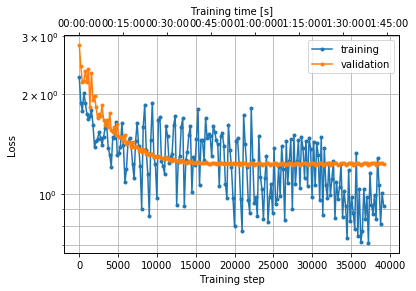

In [28]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [90]:
predictions, loss = model.predict(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN/model-39205


In [91]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN/model-39205


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 71.19 (3654 / 5133), f1 (weighted): 68.20, loss: 1.21e+00\nCPU time: 46s, wall time: 41s',
 71.1864406779661,
 68.19552228480639,
 1.208588157786093)

In [92]:
probabilities = model.probs(x_val, nclass)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN/model-39205


In [93]:
predictions = predictions.astype(np.int)

In [94]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results2/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results2/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i] and i != j]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

## test network

In [35]:
test_dataset = shrecDataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:08, 1239.84it/s]


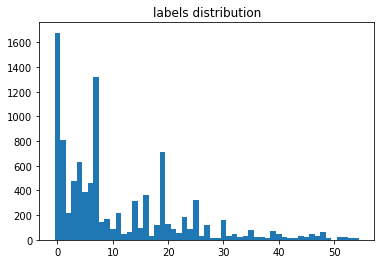

In [36]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [37]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_32sides_0noise_CNN/model-39205


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 67.41 (6920 / 10265), f1 (weighted): 64.92, loss: 1.40e+00\nCPU time: 16s, wall time: 14s',
 67.4135411592791,
 64.9200260575239,
 1.3967492337233836)

In [38]:
#predictions = model.predict(x_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_5K_32sides_0noise_CNN/model-39205


In [95]:
probabilities = model.probs(x_test, nclass)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_reg_2_32sides_0noise_CNN/model-39205


In [40]:
#predictions = predictions.astype(np.int)

write to file

In [96]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results2/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results2/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [76]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

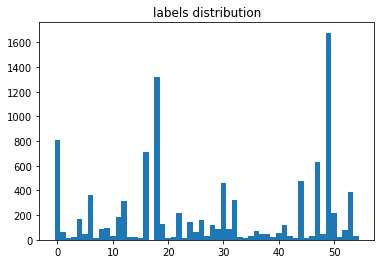

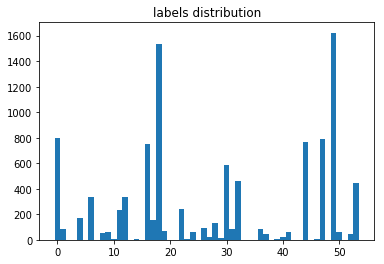

In [97]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)